In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import optuna
import catboost as cb
from sklearn.metrics import f1_score, multilabel_confusion_matrix, classification_report
from sklearn.utils import class_weight

from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
train_df = pd.read_csv("./data/preprocessed_train.csv")
train_df.head()

,title,description,action,adventure,animation,biography,comedy,crime,documentary,drama,...,mystery,romance,sci_fi,short,sport,superhero,thriller,war,western,poster_path
0,The Expanse,"In the 24th century, a group of humans untangl...",0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,./data/posters/drama/the_expanse.jpg
1,Night Stalker: The Hunt for a Serial Killer,This limited docu-series tells the true story ...,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,./data/posters/documentary/night_stalker__the_...
2,Hannah Montana: The Movie,As Hannah Montana's popularity begins to take ...,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,./data/posters/music/hannah_montana__the_movie...
3,London Kills,Drama series following the detectives of an el...,0,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,./data/posters/crime/london_kills.jpg
4,Women's Prison,A sadistic prison warden takes out her sexual ...,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,./data/posters/film_noir/women_s_prison.jpg


In [3]:
test_df = pd.read_csv("./data/preprocessed_test.csv")
test_df.head()

,title,description,action,adventure,animation,biography,comedy,crime,documentary,drama,...,mystery,romance,sci_fi,short,sport,superhero,thriller,war,western,poster_path
0,Marie Antoinette,The retelling of France's iconic but ill-fated...,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,./data/posters/biography/marie_antoinette.jpg
1,An American Crime,The true story of suburban housewife Gertrude ...,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,./data/posters/biography/an_american_crime.jpg
2,Crime Wave,Reformed parolee Steve Lacey is caught in the ...,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,./data/posters/film_noir/crime_wave.jpg
3,Bad News Bears,A grizzled little league coach tries to turn h...,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,./data/posters/sport/bad_news_bears.jpg
4,The Texas Chain Saw Massacre,Five friends head out to rural Texas to visit ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,./data/posters/horror/the_texas_chain_saw_mass...


# Combine features df

Records in both datasets must be in the same order

In [4]:
feature_df = pd.read_csv("./data/preprocessed_text_extracted.csv")
feature_df.head()

,action,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,...,description_musical,description_mystery,description_romance,description_sci_fi,description_short,description_sport,description_superhero,description_thriller,description_war,description_western
0,1,0,0,0,0,1,0,1,0,0,...,0.000729,0.016814,0.000210,0.004747,0.346715,0.000524,0.000896,0.510935,0.619829,0.060402
1,0,0,0,1,0,0,0,1,0,0,...,0.006129,0.000587,0.001922,0.003678,0.368192,0.995480,0.151028,0.803039,0.000593,0.058039
2,0,0,0,0,1,0,0,0,0,0,...,0.001905,0.925831,0.000304,0.000407,0.350758,0.000607,0.002153,0.588855,0.988317,0.001535
3,0,0,0,0,0,0,0,1,0,0,...,0.000644,0.020221,0.001567,0.834033,0.278637,0.000504,0.002298,0.895916,0.083377,0.591715
4,0,0,0,0,1,0,0,1,0,0,...,0.001886,0.002582,0.577846,0.011673,0.225869,0.001270,0.001472,0.337887,0.000121,0.520456


In [5]:
preprocessed_df = pd.read_csv("./data/preprocessed.csv")
preprocessed_df.head()

,title,description,action,adventure,animation,biography,comedy,crime,documentary,drama,...,mystery,romance,sci_fi,short,sport,superhero,thriller,war,western,poster_path
0,'71,"In 1971, a young and disoriented British soldi...",1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,./data/posters/war/_71.jpg
1,'83,"On June 25, 1983, the Lord's Cricket Ground wi...",0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,./data/posters/sport/_83.jpg
2,'Allo 'Allo!,"In France during World War II, René Artois run...",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,./data/posters/history/_allo__allo_.jpg
3,10 Cloverfield Lane,A young woman is held in an underground bunker...,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,./data/posters/sci_fi/10_cloverfield_lane.jpg
4,10 Things I Hate About You,"A pretty, popular teenager can't go out on a d...",0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,./data/posters/comedy/10_things_i_hate_about_y...


In [6]:
feature_df["title"] = preprocessed_df["title"]
feature_df["description"] = preprocessed_df["description"]

In [7]:
feature_df.isnull().any()

action                  False
adventure               False
animation               False
biography               False
comedy                  False
                        ...  
description_thriller    False
description_war         False
description_western     False
title                   False
description             False
Length: 75, dtype: bool

# Combine test_df and train_df

In [8]:
CATEGORIES = ["action", "adventure", "animation", "biography", "comedy", "crime", "documentary", "drama", "family",
              "fantasy", "film_noir", "history", "horror", "music", "musical", "mystery", "romance", "sci_fi",
              "short", "sport", "superhero", "thriller", "war", "western"]

def join_df_with_features(main_df, features_df):
    cols_to_use = features_df.columns.difference(CATEGORIES)

    return main_df.merge(features_df[cols_to_use], on=["title","description"], how="left")

In [9]:
train_df.count()

title          3332
description    3332
action         3332
adventure      3332
animation      3332
biography      3332
comedy         3332
crime          3332
documentary    3332
drama          3332
family         3332
fantasy        3332
film_noir      3332
history        3332
horror         3332
music          3332
musical        3332
mystery        3332
romance        3332
sci_fi         3332
short          3332
sport          3332
superhero      3332
thriller       3332
war            3332
western        3332
poster_path    3332
dtype: int64

In [10]:
train_df.dtypes

title          object
description    object
action          int64
adventure       int64
animation       int64
biography       int64
comedy          int64
crime           int64
documentary     int64
drama           int64
family          int64
fantasy         int64
film_noir       int64
history         int64
horror          int64
music           int64
musical         int64
mystery         int64
romance         int64
sci_fi          int64
short           int64
sport           int64
superhero       int64
thriller        int64
war             int64
western         int64
poster_path    object
dtype: object

In [11]:
feature_df.dtypes

action                    int64
adventure                 int64
animation                 int64
biography                 int64
comedy                    int64
                         ...   
description_thriller    float64
description_war         float64
description_western     float64
title                    object
description              object
Length: 75, dtype: object

In [12]:
train_df = join_df_with_features(train_df, feature_df)
print(len(train_df))
print(train_df.isnull().any().any())
train_df.head()

3332
False


,title,description,action,adventure,animation,biography,comedy,crime,documentary,drama,...,label_mystery,label_romance,label_sci_fi,label_short,label_sport,label_superhero,label_thriller,label_war,label_western,poster_path_y
0,The Expanse,"In the 24th century, a group of humans untangl...",0,0,0,0,0,0,0,1,...,0.454636,0.001686,0.992280,0.070866,0.005837,0.024310,0.359774,0.008164,0.014369,./data/posters/drama/the_expanse.jpg
1,Night Stalker: The Hunt for a Serial Killer,This limited docu-series tells the true story ...,0,0,0,0,0,1,1,0,...,0.718541,0.000067,0.245553,0.173912,0.001890,0.000446,0.994745,0.000229,0.028700,./data/posters/documentary/night_stalker__the_...
2,Hannah Montana: The Movie,As Hannah Montana's popularity begins to take ...,0,0,0,0,1,0,0,1,...,0.000163,0.000503,0.000164,0.362667,0.000313,0.000197,0.000299,0.000080,0.000274,./data/posters/music/hannah_montana__the_movie...
3,London Kills,Drama series following the detectives of an el...,0,0,0,0,0,1,0,1,...,0.000426,0.000189,0.044832,0.395628,0.032333,0.002007,0.957332,0.835014,0.240445,./data/posters/crime/london_kills.jpg
4,Women's Prison,A sadistic prison warden takes out her sexual ...,0,0,0,0,0,1,0,1,...,0.003278,0.000061,0.003817,0.466918,0.000220,0.000107,0.135566,0.000145,0.537468,./data/posters/film_noir/women_s_prison.jpg


In [13]:
test_df = join_df_with_features(test_df, feature_df)
print(len(test_df))
print(test_df.isnull().any().any())
test_df.head()

834
True


,title,description,action,adventure,animation,biography,comedy,crime,documentary,drama,...,label_mystery,label_romance,label_sci_fi,label_short,label_sport,label_superhero,label_thriller,label_war,label_western,poster_path_y
0,Marie Antoinette,The retelling of France's iconic but ill-fated...,0,0,0,1,0,0,0,1,...,0.001912,0.004439,0.000149,0.380833,0.000451,0.000081,0.063823,0.000923,0.000560,./data/posters/biography/marie_antoinette.jpg
1,An American Crime,The true story of suburban housewife Gertrude ...,0,0,0,1,0,1,0,1,...,0.005091,0.000070,0.000220,0.234580,0.000143,0.000081,0.040764,0.009551,0.066513,./data/posters/biography/an_american_crime.jpg
2,Crime Wave,Reformed parolee Steve Lacey is caught in the ...,0,0,0,0,0,1,0,1,...,0.000369,0.000058,0.001862,0.185317,0.000108,0.000437,0.063112,0.001195,0.320638,./data/posters/film_noir/crime_wave.jpg
3,Bad News Bears,A grizzled little league coach tries to turn h...,0,0,0,0,1,0,0,0,...,0.000260,0.000059,0.004160,0.368054,0.031000,0.000102,0.004676,0.035084,0.394523,./data/posters/sport/bad_news_bears.jpg
4,The Texas Chain Saw Massacre,Five friends head out to rural Texas to visit ...,0,0,0,0,0,0,0,0,...,0.000133,0.000066,0.001017,0.128972,0.070404,0.000085,0.735335,0.201196,0.987588,./data/posters/horror/the_texas_chain_saw_mass...


In [14]:
test_df.isnull().sum()

title              0
description        0
action             0
adventure          0
animation          0
                  ..
label_superhero    1
label_thriller     1
label_war          1
label_western      1
poster_path_y      1
Length: 76, dtype: int64

In [15]:
test_df = test_df.dropna()

# Show barchart categories

In [16]:
cunt_classes = feature_df[CATEGORIES].sum()

<AxesSubplot: >

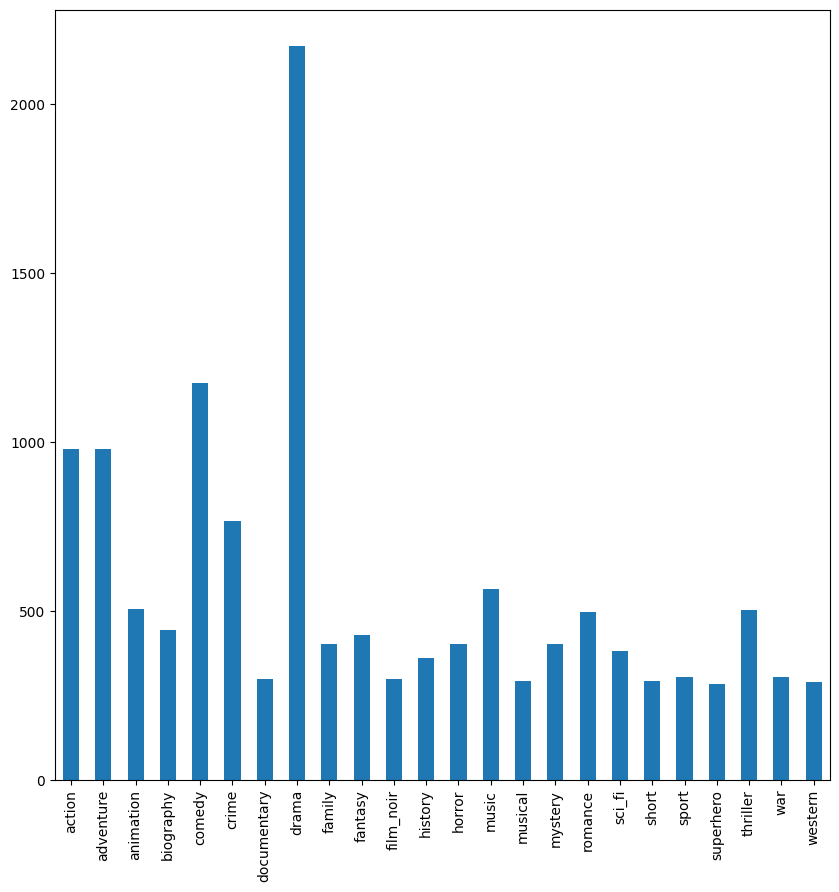

In [17]:
cunt_classes.plot.bar(figsize=(10,10))

# Now we have clean test_df and train_df

In [18]:
LABEL_FEATURES = [f"label_{elem}" for elem in CATEGORIES]
DESCRIPTION_FEATURES = [f"description_{elem}" for elem in CATEGORIES]

train_x = train_df[LABEL_FEATURES + DESCRIPTION_FEATURES]
train_y = train_df[CATEGORIES]

test_x = test_df[LABEL_FEATURES + DESCRIPTION_FEATURES]
test_y = test_df[CATEGORIES]

In [19]:
train_x.head()

,label_action,label_adventure,label_animation,label_biography,label_comedy,label_crime,label_documentary,label_drama,label_family,label_fantasy,...,description_musical,description_mystery,description_romance,description_sci_fi,description_short,description_sport,description_superhero,description_thriller,description_war,description_western
0,0.511891,0.981408,0.032416,0.000969,0.011346,0.008455,0.060555,0.346816,0.002794,0.132605,...,0.000740,0.317154,0.000449,0.856629,0.196089,0.000729,0.011351,0.741262,0.017145,0.276600
1,0.697175,0.009638,0.005448,0.001408,0.000176,0.988274,0.985005,0.937122,0.001242,0.003418,...,0.000268,0.003073,0.000352,0.001970,0.998835,0.003108,0.001835,0.022596,0.000994,0.143081
2,0.702380,0.749389,0.994899,0.000796,0.877986,0.000157,0.768765,0.083131,0.023967,0.056424,...,0.851159,0.003346,0.002251,0.001172,0.295312,0.000739,0.010129,0.028097,0.000872,0.138391
3,0.953714,0.006597,0.026449,0.030994,0.022163,0.981164,0.195441,0.916526,0.121850,0.002362,...,0.000193,0.040487,0.000206,0.000485,0.133705,0.000194,0.000660,0.898588,0.000246,0.041857
4,0.733417,0.005805,0.022389,0.003179,0.020399,0.879740,0.074105,0.548306,0.000191,0.001778,...,0.000167,0.000405,0.000088,0.003043,0.029012,0.001647,0.001562,0.160694,0.002392,0.013110


In [20]:
train_y.head()

,action,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,...,musical,mystery,romance,sci_fi,short,sport,superhero,thriller,war,western
0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
test_x.head()

,label_action,label_adventure,label_animation,label_biography,label_comedy,label_crime,label_documentary,label_drama,label_family,label_fantasy,...,description_musical,description_mystery,description_romance,description_sci_fi,description_short,description_sport,description_superhero,description_thriller,description_war,description_western
0,0.687798,0.026415,0.027435,0.943681,0.010625,0.400680,0.115591,0.857297,0.067509,0.004349,...,0.012018,0.005152,0.005256,0.000818,0.238532,0.000308,0.011111,0.866153,0.001273,0.278460
1,0.087994,0.000294,0.000209,0.000275,0.000095,0.997961,0.026638,0.486672,0.000539,0.000104,...,0.000229,0.004134,0.000143,0.000225,0.294827,0.000308,0.000200,0.740809,0.000121,0.006650
2,0.411938,0.000382,0.009991,0.000621,0.000067,0.990122,0.007970,0.127605,0.001307,0.000428,...,0.003172,0.005679,0.002416,0.009350,0.263471,0.027278,0.109883,0.885601,0.165048,0.285093
3,0.297028,0.000298,0.039989,0.035719,0.001668,0.429163,0.083298,0.674033,0.468613,0.000166,...,0.000885,0.000376,0.000133,0.001561,0.208180,0.991006,0.047525,0.766784,0.000065,0.258282
4,0.924996,0.001259,0.001565,0.001075,0.000108,0.995538,0.100940,0.403728,0.000986,0.000196,...,0.002261,0.796814,0.001037,0.365445,0.361597,0.036113,0.006582,0.940203,0.008029,0.721087


In [22]:
test_y.head()

,action,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,...,musical,mystery,romance,sci_fi,short,sport,superhero,thriller,war,western
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Let's create catboost classifier with optuna

In [29]:
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["MultiLogloss", "MultiCrossEntropy"]),
        "n_estimators": trial.suggest_int("n_estimators", 5, 1000),
        "depth": trial.suggest_int("depth", 1, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.0001, 0.1),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "random_seed": 2022,
        "used_ram_limit": "10gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(test_x, test_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(test_x)
    F1_score = f1_score(test_y, preds, average='weighted')
    return F1_score


In [30]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=2022))
study.optimize(objective, timeout=1200, n_jobs=4) # two hours

[I 2022-11-24 00:13:59,408] A new study created in memory with name: no-name-5493b2a3-c46d-45e5-97a1-0042656be44f
[I 2022-11-24 00:14:09,590] Trial 0 finished with value: 0.13626587161259263 and parameters: {'objective': 'MultiCrossEntropy', 'n_estimators': 117, 'depth': 1, 'learning_rate': 0.06857221866488487, 'l2_leaf_reg': 0.04875010801475147, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.2113492916468545}. Best is trial 0 with value: 0.13626587161259263.
/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
[W 2022-11-24 00:27:53,109] Trial 1 failed because of the following error: KeyboardInterrupt('')
Traceback (most recent call last):
  File "/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3

KeyboardInterrupt: 

In [ ]:
study.best_value

In [ ]:
study.best_params

In [29]:
final_model = cb.CatBoostClassifier(**study.best_params)

In [30]:
final_model.fit(train_x, train_y, eval_set=[(test_x, test_y)], verbose=0, early_stopping_rounds=100)

/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [33]:
preds = final_model.predict(test_x)

/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [55]:
preds

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [53]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.80      0.46      0.58       191
           1       0.76      0.48      0.59       186
           2       0.73      0.34      0.46        95
           3       0.59      0.24      0.34        82
           4       0.72      0.43      0.54       238
           5       0.70      0.62      0.66       142
           6       0.93      0.36      0.52        72
           7       0.71      0.81      0.76       430
           8       0.79      0.13      0.22        86
           9       0.71      0.15      0.25        80
          10       0.79      0.31      0.44        62
          11       0.65      0.20      0.31        64
          12       0.75      0.46      0.57        72
          13       0.83      0.57      0.68       110
          14       0.61      0.21      0.31        53
          15       0.78      0.09      0.17        74
          16       0.67      0.21      0.32        94
          17       0.74    

/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
cm = multilabel_confusion_matrix(test_y, preds)
cm

array([[[620,  22],
        [104,  87]],

       [[619,  28],
        [ 96,  90]],

       [[726,  12],
        [ 63,  32]],

       [[737,  14],
        [ 62,  20]],

       [[554,  41],
        [135, 103]],

       [[654,  37],
        [ 54,  88]],

       [[759,   2],
        [ 46,  26]],

       [[261, 142],
        [ 80, 350]],

       [[744,   3],
        [ 75,  11]],

       [[748,   5],
        [ 68,  12]],

       [[766,   5],
        [ 43,  19]],

       [[762,   7],
        [ 51,  13]],

       [[750,  11],
        [ 39,  33]],

       [[710,  13],
        [ 47,  63]],

       [[773,   7],
        [ 42,  11]],

       [[757,   2],
        [ 67,   7]],

       [[729,  10],
        [ 74,  20]],

       [[756,  10],
        [ 38,  29]],

       [[778,   0],
        [ 52,   3]],

       [[759,   2],
        [ 21,  51]],

       [[781,   5],
        [ 21,  26]],

       [[723,   8],
        [100,   2]],

       [[762,   7],
        [ 36,  28]],

       [[768,   3],
        [ 35, 

TypeError: Invalid shape (24, 2, 2) for image data

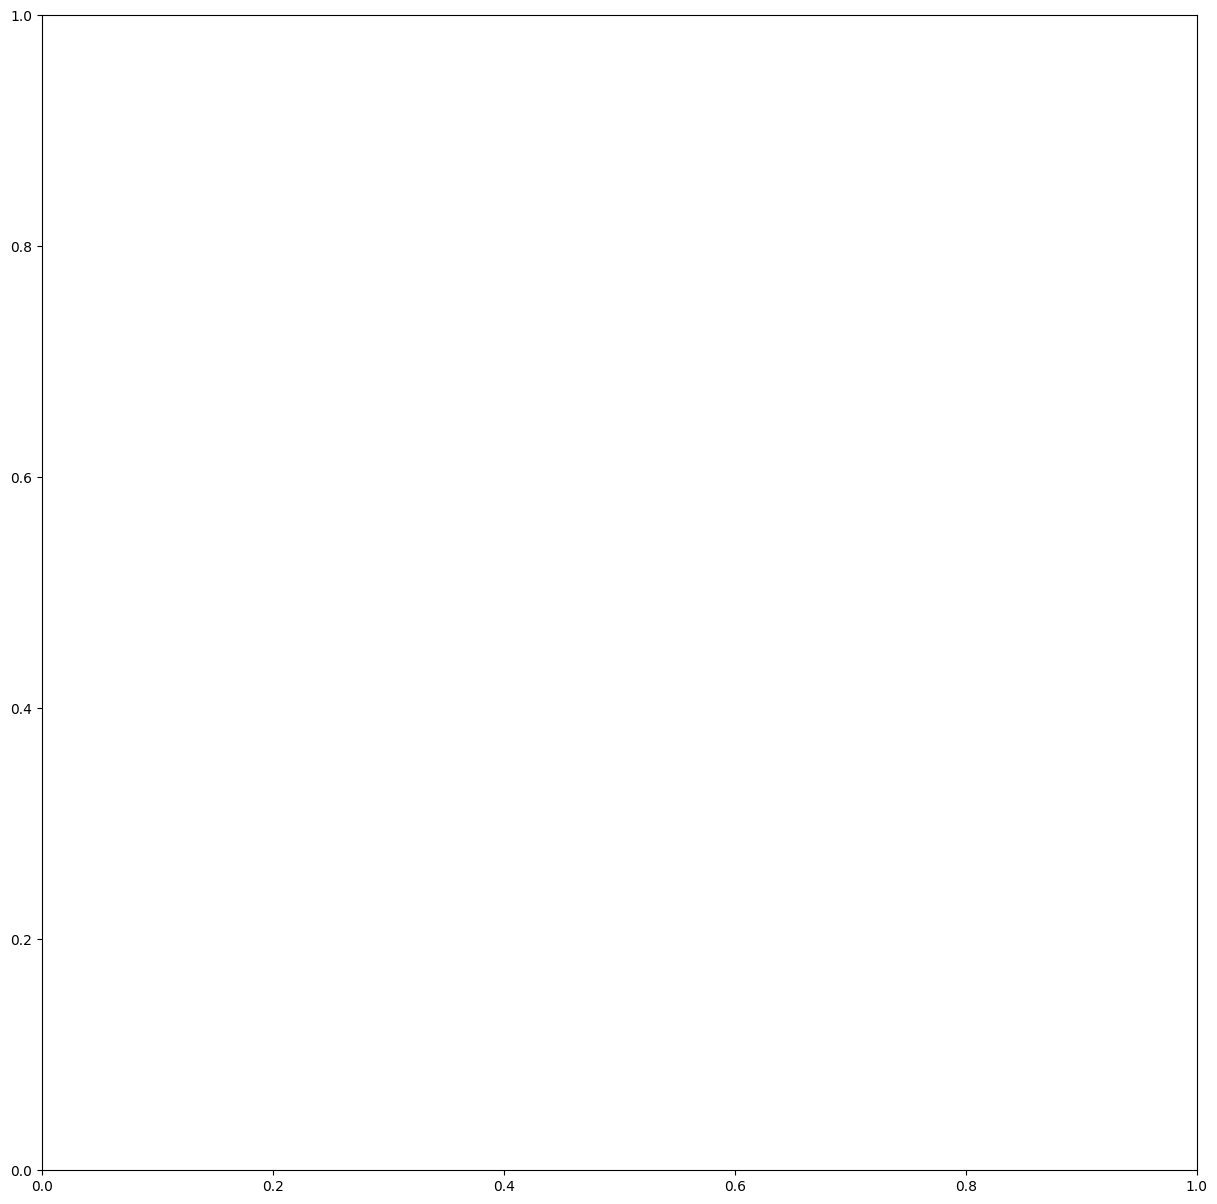

In [48]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + CATEGORIES)
ax.set_yticklabels([''] + CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()